In [1]:
# Code from Heineck et al. 2022 for automated rating of lentil disease severity

In [2]:
import sys
import os
import numpy as np
import random
import matplotlib.pyplot as plt
sys.path.insert(0, ".")
import cv2
from pandas import read_csv, read_excel, DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from pyzbar import pyzbar

import logging

logging.basicConfig(level=logging.INFO)
np.random.seed(42)
random.seed(42) 
# load all image files, sorting them to
# ensure that they are aligned
p = "./"
plrte = os.path.join(p,'TestImages')
plrtr = os.path.join(p,'TrainImages')
plrr = os.path.join(p,'Results')
plrp = os.path.join(p,'Temp')

In [3]:
## Create some utility functions for loading and processing images

In [4]:
def decode(image):
    # decodes all barcodes from an image
    decoded_objects = pyzbar.decode(image)
    if len(decoded_objects)>0:
        for obj in decoded_objects:
            # draw the barcode
            logging.info("detected barcode:"+obj.data.decode('utf-8'))
        return image, obj.data.decode('utf-8')
    else:
        return image, []
def area(bbox):
        if len(bbox)>0: 
            return (bbox[3]-bbox[1])*(bbox[2]-bbox[0])
        else:
            return 0

class LentilRootRotDataset():
    def __init__(self, names_list,path):
        self.img_names = names_list
        self.path = path
    def __getitem__(self, idx):
        # load images and targets
        f = self.img_names[idx]
        img = cv2.imread(os.path.join(self.path,f))
        h,w = img.shape[0],img.shape[1]
        if h<w:
            h,w=w,h
            logging.debug('Transpose')
            img=np.flipud(np.transpose(img,[1,0,2]))         

        
        crop=.3
        
        bhb = int(h*.23)
        thb = int(h*.1)
        wb = int(w*crop/2)
        
        bimg = img[0:bhb,:]

        _, barcode = decode(bimg)
        
        img = img[bhb:(h-thb),wb:(w-wb),:]
        logging.info(f)
        
        #write cropped image
        file = 'c'+f
        cv2.imwrite(os.path.join(plrp,file),img)
      
        target = {}
        target['barcode'] = [barcode]
        target['image_id'] = [idx]
        target['image_name'] = [f]
        
        return img, target
    def __len__(self):
        return len(self.img_names)

def resize(img,factor):
    image_scale_down = 3
    y = (int)(img.shape[0]/image_scale_down)
    x = (int)(img.shape[1]/image_scale_down)
    image = cv2.resize(img, (x,y))
    return image

def contour_sizes(mask,erode=False,dilate=False):
    #get information about the countours derived from segmented images
    if erode:
        kernel = np.ones((5,5),np.uint8)
        mask = cv2.erode(mask,kernel,iterations = 1)
    if dilate:
        kernel = np.ones((5,5),np.uint8)
        mask = cv2.dilate(mask,kernel,iterations = 1)       

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    
    bbox_coords = []
    A = []
    cx = []
    cy = []
    aspect = []
    hull = []

    #loop through detected contours
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
        bbox_coords.append([boundRect[i][0],boundRect[i][1],boundRect[i][0]+boundRect[i][2],boundRect[i][1]+boundRect[i][3],k])
        hull.append(cv2.convexHull(contours[i], False))
        M = cv2.moments(c)
        #get contour momemts for classification later
        try:
            cx.append(int(M['m10']/M['m00']))
            cy.append(int(M['m01']/M['m00']))
        except:
            cx.append(0)
            cy.append(0)
        try:
            cxx = int(M['mu20']/M['m00'])#-cx[-1]*cx[-1]
            cxy = int(M['mu11']/M['m00'])#-cx[-1]*cy[-1]
            cyy = int(M['mu02']/M['m00'])#-cy[-1]*cy[-1]
            l2 = 8*(cxx+cyy+np.sqrt(4*cxy*cxy+(cxx-cyy)**2))
            w2 = 8*(cxx+cyy-np.sqrt(4*cxy*cxy+(cxx-cyy)**2))
            l = np.sqrt(l2)
            if w2>0:
                w = np.sqrt(w2)
            else:
                w=0
            if w>0:
                aspect.append(l/w)
            else:
                aspect.append(0)
        except:
            aspect.append(0)
        A.append(cv2.contourArea(c))
    A = np.array(A)
    cx = np.array(cx)
    cy = np.array(cy)
    sort = np.argsort(A)
    return hull, boundRect, bbox_coords, A, cx, cy, aspect, sort

#following functions detect overlap between bounding boxes around detected contours
def check_vertical_overlap(bbox1,bbox2):
    A1 = area(bbox1)
    A2 = area(bbox2)
    if A2>A1:
        if bbox1[1]<bbox2[1]:
            #it's at least partially above
            if bbox1[3]<bbox2[3]:
                #fully above
                f1 = 1
                f2 = 0
            else:
                f1 = (bbox2[1]-bbox1[1])/(bbox1[3]-bbox1[1])
                f2 = (bbox1[3]-bbox2[1])/(bbox1[3]-bbox1[1]) 
                #partial overlap
        else:
            if bbox1[3]<bbox2[3]:
                #fully contained
                f1 = 1
                f2 = 1
            else:
                f1 = (bbox2[3]-bbox1[1])/(bbox1[3]-bbox1[1])
                f2 = (bbox1[3]-bbox2[3])/(bbox1[3]-bbox1[1]) 
                #partial overlap       
    else:
        if bbox2[1]<bbox1[1]:
            #it's at least partially above
            if bbox2[3]<bbox1[3]:
                #fully below
                f1 = 0
                f2 = 1
            else:
                f1 = (bbox1[1]-bbox2[1])/(bbox2[3]-bbox2[1])
                f2 = (bbox2[3]-bbox1[1])/(bbox2[3]-bbox2[1]) 
                #partial overlap
        else:
            if bbox2[3]<bbox1[3]:
                #fully contained
                f1 = 1
                f2 = 1
            else:
                f1 = (bbox1[3]-bbox2[1])/(bbox2[3]-bbox2[1])
                f2 = (bbox2[3]-bbox1[3])/(bbox2[3]-bbox2[1]) 
                #partial overlap
        
    return f1, f2

def bbox_contains(bbox1,bbox2):
    if area(bbox1)>=area(bbox2):
        cx = (bbox2[0]+bbox2[2])/2 
        cy = (bbox2[1]+bbox2[3])/2  
        if cx<=bbox1[2] and cx>=bbox1[0] and cy<=bbox1[3] and cy>=bbox1[1]:
            return [False, True]#1 contains 2
        else:
            return [False, False]
    else:
        cx = (bbox1[0]+bbox1[2])/2 
        cy = (bbox1[1]+bbox1[3])/2  
        if cx<=bbox2[2] and cx>=bbox2[0] and cy<=bbox2[3] and cy>=bbox2[1]:
            return [True,  False]#2 contains 1
        else:
            return [False, False]

def check_horizontal_overlap(bbox1,bbox2):
    A1 = area(bbox1)
    A2 = area(bbox2)
    if A2>A1:
        if bbox1[0]<bbox2[0]:
            #it's at least partially left
            if bbox1[2]<bbox2[2]:
                #fully left
                f1 = 1
                f2 = 0
            else:
                f1 = (bbox2[0]-bbox1[0])/(bbox1[2]-bbox1[0])
                f2 = (bbox1[2]-bbox2[0])/(bbox1[2]-bbox1[0]) 
                #partial overlap
        else:
            if bbox1[2]<bbox2[2]:
                #fully contained
                f1 = 1
                f2 = 1
            else:
                f1 = (bbox2[2]-bbox1[0])/(bbox1[2]-bbox1[0])
                f2 = (bbox1[2]-bbox2[2])/(bbox1[2]-bbox1[0]) 
                #partial overlap       
    else:
        if bbox2[0]<bbox1[0]:
            #it's at least partially right
            if bbox2[3]<bbox1[3]:
                #fully right
                f1 = 0
                f2 = 1
            else:
                f1 = (bbox1[0]-bbox2[0])/(bbox2[2]-bbox2[0])
                f2 = (bbox2[2]-bbox1[0])/(bbox2[2]-bbox2[0]) 
                #partial overlap
        else:
            if bbox2[2]<bbox1[2]:
                #fully contained
                f1 = 1
                f2 = 1
            else:
                f1 = (bbox1[2]-bbox2[0])/(bbox2[2]-bbox2[0])
                f2 = (bbox2[2]-bbox1[2])/(bbox2[2]-bbox2[0]) 
                #partial overlap
        
    return f1, f2

#calculate the local standard deviation of a patch of pixels - a feature used in classification
def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd

#calculate features from image - 3 colors (L*a*b) and 3 scales of standard deviation
def features(img,nsd):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    sd1 = localSD(l,nsd)
    sd2 = localSD(l,int((nsd+1)/2-1))
    sd3 = localSD(l,int((nsd+1)/4-1))
    l = l.reshape((-1,1))
    a = a.reshape((-1,1))
    b = b.reshape((-1,1))
    sd1 = sd1.reshape((-1,1))
    sd2 = sd2.reshape((-1,1))
    sd3 = sd3.reshape((-1,1))
    return np.hstack((l,a,b,sd1,sd2,sd3))

In [5]:
## Fit RandomForest classifier using labeled images in the ./TrainImages folder using best hyperparameters found through GridSearchCV.

INFO:root:detected barcode:n1062
INFO:root:n1062.JPG


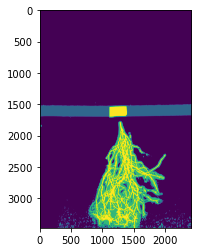

INFO:root:detected barcode:n0955
INFO:root:n0955.JPG


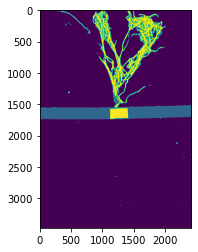

INFO:root:detected barcode:n0796
INFO:root:n0796.JPG


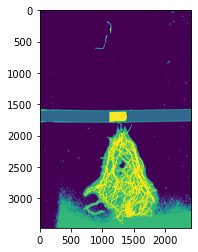

INFO:root:detected barcode:n0563
INFO:root:n0563.JPG


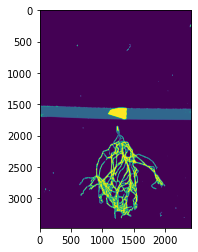

INFO:root:detected barcode:n0486
INFO:root:n0486.JPG


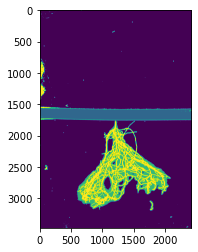

INFO:root:detected barcode:n0212
INFO:root:n0212.JPG


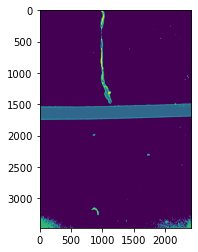

INFO:root:detected barcode:n0169
INFO:root:n0169.JPG


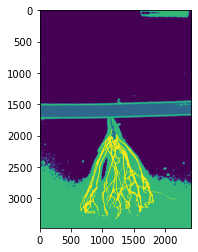

INFO:root:detected barcode:n0017
INFO:root:n0017.JPG


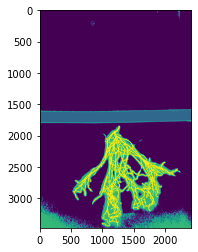

In [6]:
names_list = []
test_list = []

for f in sorted(os.listdir(plrtr),reverse=True):
    logging.debug(f)
    if ('c' not in f) and ('.jpg' in f or '.JPG' in f):
        if ('Segment' not in f) and ('Mask' not in f):
            if ('IMG' not in f):
                names_list.append(f)
            else:
                test_list.append(f)
        else:
            pass
    elif 'csv' in f:
        scores_df = read_csv(os.path.join(plrtr,f))
    else:
        pass
     
# use our dataset and defined transformations
dataset = LentilRootRotDataset(names_list,plrtr)

n_img = len(dataset)
n_features = 6
n_sd = 511
parameters= { 
    'n_estimators': [100,200],
    'max_features': ['sqrt'],
    'max_depth' : [4,8],
    'criterion' :['gini']}
scale = StandardScaler()
rfc = RandomForestClassifier()
clf_rfc = GridSearchCV(rfc, parameters,n_jobs=-1)
healthy_class = 3
disease_class = 1
Zall = []
Lall = []
i = 0
for imgc, target in dataset:    
    Z = features(imgc,n_sd)
    idx = target['image_id'][0]
    name = names_list[idx]
    label_file = 'cl' + name.split('.')[0]+'.tif'
    imgl = cv2.imread(os.path.join(plrtr,label_file),cv2.IMREAD_UNCHANGED)
    plt.imshow(imgl)
    plt.show()
    L = imgl.reshape((-1,1))

    # convert to np.float32
    Z = np.float32(Z)
    if i==0:
        Zall = Z
        Lall = L
    else:
        Zall = np.vstack((Zall,Z))
        Lall = np.vstack((Lall,L))
    i = i+1
Lall = Lall.ravel()

In [7]:
Zall = scale.fit_transform(Zall)

In [ ]:
clf_rfc.fit(Zall,Lall)
clf_rfc.best_params_

In [ ]:
model = clf_rfc.best_estimator_

In [ ]:
## Apply fitted model to segment images, detect contours, classify as root/shoot, then calculate disease ratings.

In [ ]:
tape_crop = 50
root_area_min = 100
shoot_area_min = 100
shoot_area_max = 7000
aspect_min = 1.4
aspect_max = 19
shoot_bound = 200
thin_shoot_aspect = 8
thin_shoot_area = 500
big_root_thresh = 450000

def check_shoot(caspect,carea,cbbox):
    return aspect_max>caspect>aspect_min and shoot_area_max>carea>shoot_area_min# and np.sqrt((cbbox[3]-cbbox[1])**2+(cbbox[2]-cbbox[0])**2)<shoot_bound

for f in sorted(os.listdir(plrte),reverse=True):
    logging.debug(f)
    if ('c' not in f) and ('.jpg' in f or '.JPG' in f):
        if ('Segment' not in f) and ('Mask' not in f):
            if ('IMG' not in f):
                names_list.append(f)
            else:
                test_list.append(f)
        else:
            pass
    elif 'xl' in f:
        scores_df = read_excel(os.path.join(plrte,f), sheet_name='Sheet1', skiprows=10, na_values='.')
    else:
        pass
dataset = LentilRootRotDataset(test_list,plrte)
n_img = len(dataset)
output_df = DataFrame(columns=[*scores_df.keys(),'shoot.score','root.score','shoot.area','root.area','img.name'])

big_root = np.zeros([n_img,])*np.nan
iii = 0
#loop through images in ./TestImages
for imgc, target in dataset:      
    Z = features(imgc,n_sd) 
    idx = target['image_id'][0]
    
    name = test_list[idx]
    
    # convert to np.float32
    Z = scale.transform(np.float32(Z))
    classes = model.predict(Z).reshape((imgc.shape[0:2]))
    for k in [disease_class,healthy_class]:
        #segment 1 is diseased/tape
        #segment 3 is healthy
        mask_out = np.ones((imgc.shape[0:2]))*0
        file = 'c'+name.split('.')[0]+'_Segment_'+str(k)+'.jpg'
        
        mask_out[classes==k] = 255
        mask_out = mask_out.astype(np.uint8)
        cv2.imwrite(os.path.join(plrp,file),mask_out)
        
        #calculate contours and shape parameters
        hull, boundRect, bbox_coords, A, cx, cy, aspect,  sort = contour_sizes(mask_out,erode=False)
        hull_erode, boundRect_erode, bbox_coords_erode, A_erode, cx_erode, cy_erode, aspect_erode, sort_erode = contour_sizes(mask_out,erode=True)

        #where's the root?
        #the the highest "diseased" area in the image is actually the tape
        if k==disease_class:
            tape_x = cx_erode[sort_erode[-1]]
            tape_y = cy_erode[sort_erode[-1]]
            tape_bbox = bbox_coords_erode[sort_erode[-1]]
            
        if k==healthy_class:
            root_x = cx[sort[-1]]
            root_y = cy[sort[-1]]
                
            if root_y<tape_y:#above tape
                mask_crop = np.flipud(classes[0:(tape_bbox[1]-tape_crop),:])
                imgc_crop = cv2.UMat(np.flipud(imgc[0:(tape_bbox[1]-tape_crop),:].astype(np.uint8)))
                #as y increases, we go root->shoot so flip to ease code
            else:
                mask_crop = classes[(tape_bbox[3]+tape_crop):-1,:]
                imgc_crop = cv2.UMat(imgc[(tape_bbox[3]+tape_crop):-1,:].astype(np.uint8))
            
    mask_crop_healthy, mask_crop_disease = np.zeros(mask_crop.shape), np.zeros(mask_crop.shape)
    
    mask_crop_healthy[mask_crop==healthy_class]=255
    mask_crop_disease[mask_crop==disease_class]=255
    mask_crop_healthy = mask_crop_healthy.astype(np.uint8)
    mask_crop_disease = mask_crop_disease.astype(np.uint8)
    
    top_healthy = {'A':[],'bbox':[],'cx':[],'cy':[], 'aspect':[]}#, 'percent':[]}
    top_disease = {'A':[],'bbox':[],'cx':[],'cy':[], 'aspect':[]}#, 'percent':[]}
    
    #healthy
    hull_healthy, boundRect_healthy, bbox_coords_healthy, A_healthy, cx_healthy, cy_healthy, aspect_healthy, sort_healthy = contour_sizes(mask_crop_healthy) 

    #sort through top 8 by area healthy contours and create a dictionary of features for each
    for i in range(1,min(len(sort_healthy),8)):
        ii = sort_healthy[-i]
    
        top_healthy['A'].append(A_healthy[ii])
        top_healthy['bbox'].append(bbox_coords_healthy[ii][0:4])
        top_healthy['cx'].append(cx_healthy[ii])
        top_healthy['cy'].append(cy_healthy[ii])
        top_healthy['aspect'].append(aspect_healthy[ii])
    
    hull_disease, boundRect_disease, bbox_coords_disease, A_disease, cx_disease, cy_disease, aspect_disease, sort_disease = contour_sizes(mask_crop_disease)

    #now loop through diseased contours
    for i in range(1,min(len(sort_disease),8)):
        ii = sort_disease[-i]
    
        #cv2.rectangle(drawn_disease, (boundRect_disease[ii][0],boundRect_disease[ii][1]), (boundRect_disease[ii][0]+boundRect_disease[ii][2],boundRect_disease[ii][1]+boundRect_disease[ii][3]), (0,255,0), 6)
        top_disease['A'].append(A_disease[ii])
        top_disease['bbox'].append(bbox_coords_disease[ii][0:4])
        top_disease['cx'].append(cx_disease[ii])
        top_disease['cy'].append(cy_disease[ii])
        top_disease['aspect'].append(aspect_disease[ii])
 
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # fontScale
    fontScale = 2
    color = (0, 255, 0)
    thickness = 6
    
    #now refine labeling by determining if it is root or shoot
    top_disease['part_label']=[]
    top_healthy['part_label']=[]
    
    top_disease['health_label']=[]
    top_healthy['health_label']=[]
    
    try:
        top_healthy['health_label'].append(0)
        top_healthy['part_label'].append(np.nan)  
    except:
        pass
    
    if len(top_healthy['A'])>0:
        a = top_healthy['bbox'][0]
        for i in range(1,len(top_healthy['A'])):
            top_healthy['health_label'].append(0)
            top_healthy['part_label'].append(np.nan)                      
    try:    
        top_disease['health_label'].append(1)
        top_disease['part_label'].append(np.nan)  
    except:
        pass   
    if len(top_disease['A'])>0:
        a = top_disease['bbox'][0]
        for i in range(1,len(top_disease['A'])):
            top_disease['health_label'].append(1) 
            top_disease['part_label'].append(np.nan)     
        
    #we need to elimiate pieces of tape sort the contours from the top of the image to the bottom using the bounding boxes
    if len(top_healthy['bbox'])>0:
        #filter out potential tape here - check bbox for left or right corners and remove from list:
        tape_ids_healthy = []
        for idx,bbox in enumerate(top_healthy['bbox'][:]):
            if bbox[1]==0 and top_healthy['A'][idx]<200:
                logging.info('it\'s tape')
                tape_ids_healthy.append(idx)
        for k in top_healthy.keys():
            if len(tape_ids_healthy)>0:
                for l in sorted(tape_ids_healthy,reverse=True):
                    del top_healthy[k][l]
        if len(top_healthy['bbox'])>0:
            sort_healthy = np.argsort(np.array(top_healthy['bbox'][:])[:,1])
            for k in top_healthy.keys():
                top_healthy[k]=np.array(top_healthy[k])[sort_healthy]         
                
    if len(top_disease['bbox'])>0:        
        #filter out potential tape here - check bbox for left or right corners and remove from list:
        tape_ids_disease = []
        for idx,bbox in enumerate(top_disease['bbox'][:]):
            if bbox[1]==0 and top_disease['A'][idx]<200:
                logging.info('it\'s tape')
                tape_ids_disease.append(idx)
        for k in top_disease.keys():
            if len(tape_ids_disease)>0:
                for l in sorted(tape_ids_disease,reverse=True):
                    del top_disease[k][l]
        if len(top_disease['bbox'])>0:
            sort_disease = np.argsort(np.array(top_disease['bbox'][:])[:,1])#top-to-bottom
            for k in top_disease.keys():
                top_disease[k]=np.array(top_disease[k])[sort_disease]    
            
    
    top = {'A':[],'bbox':[],'cx':[],'cy':[], 'aspect':[], 'health_label':[], 'part_label':[]}
    for k in top_healthy.keys():
        top[k]=[*top_healthy[k],*top_disease[k]]
    if len(top['bbox'])>0:#check that it's not totally empty
        sort = np.argsort(np.array(top['bbox'][:])[:,1])#top-to-bottom
        for k in top.keys():
            top[k]=np.array(top[k])[sort]

        maxloc = np.argwhere(top['A']==np.max(top['A']))[0][0]

        topy = top['bbox'][0][1]
        #examine in two passes for clarity.
        #first pass: size and shape and region
        for i in range(len(top['A'])):
            if check_shoot(top['aspect'][i],top['A'][i],top['bbox'][i]) and top['bbox'][i][1]<(topy+shoot_bound):
                top['part_label'][i]=0
                if top['A'][i]<shoot_area_min: top['A'][i]=0
            else:
                top['part_label'][i]=1
                if top['A'][i]<root_area_min: top['A'][i]=0
            logging.debug('Top y: {0:3f},{1:3f}'.format(topy,top['bbox'][i][1]))
        
        #create logical masks for diseased root, healthy root, diseased shoot, healthy shoot
        dr_mask = np.array(top['part_label']==1) & np.array(top['health_label']==1)
        hr_mask = np.array(top['part_label']==1) & np.array(top['health_label']==0)
        ds_mask = np.array(top['part_label']==0) & np.array(top['health_label']==1)
        hs_mask = np.array(top['part_label']==0) & np.array(top['health_label']==0)
        s_mask = np.array(top['part_label']==0)

        #find the largest healthy root area - if it's small, could be disease
        max_healthy_root = np.max(top['A'][hr_mask])
        max_hr_loc = np.argwhere(top['A']==max_healthy_root)[0][0]
        big_root[iii] = max_healthy_root

        #check for thin, dead shoot
        for i in range(len(top['A'])):
            if top['part_label'][i]==0:
                if top['A'][i]<thin_shoot_area and top['aspect'][i]>thin_shoot_aspect:
                    top['health_label'][i]=1#sickly    

        #check if the main root is sickly - it will have a small area
        if top['A'][max_hr_loc]<big_root_thresh:
            top['health_label'][max_hr_loc]=1
            #somewhat disease

        #half disease mask - partially diseased based on size
        hdr_mask = np.array(top['A'] == max_healthy_root) & np.array(top['health_label']==1)
        #other masks
        dr_mask = np.array(top['part_label']==1) & np.array(top['health_label']==1) & ~hdr_mask
        hr_mask = np.array(top['part_label']==1) & np.array(top['health_label']==0)
        ds_mask = np.array(top['part_label']==0) & np.array(top['health_label']==1)
        hs_mask = np.array(top['part_label']==0) & np.array(top['health_label']==0)
        s_mask = np.array(top['part_label']==0)    

        #sum areas for score
        disease_root_area = np.sum(top['A'][dr_mask])+(big_root_thresh-np.sum(top['A'][hdr_mask]))/big_root_thresh*np.sum(top['A'][hdr_mask])
        healthy_root_area = np.sum(top['A'][hr_mask])+(np.sum(top['A'][hdr_mask]))/big_root_thresh*np.sum(top['A'][hdr_mask])
        root_area = disease_root_area+healthy_root_area

        disease_shoot_area = np.sum(top['A'][ds_mask])
        healthy_shoot_area = np.sum(top['A'][hs_mask])
        shoot_area = disease_shoot_area+healthy_shoot_area

        edge_cases = {'part':[],'bbox':[]}
        #second pass: edge cases

        #check if shoot detected
        if shoot_area>0:
            #check if shoot id'd, but below the highest root point - -obviously wrong
            min_y = min(np.array(top['bbox'][s_mask])[:,1])
            if min_y>top['bbox'][maxloc][1]:
                v1,v2 = check_vertical_overlap(top['bbox'][maxloc],top['bbox'][s_mask][0,:])
                h1,h2 = check_horizontal_overlap(top['bbox'][maxloc],top['bbox'][s_mask][0,:])
                if h1>0 and h2>0 and v1==1 and v2==1:#fully contained within larger bounding box vertically and at least partially horizontally
                    healthy_root  = mask_crop_healthy[(top['bbox'][maxloc][1]+shoot_bound):top['bbox'][maxloc][3],top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage
                    disease_root  = mask_crop_disease[(top['bbox'][maxloc][1]+shoot_bound):top['bbox'][maxloc][3],top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage
                    healthy_shoot = mask_crop_healthy[top['bbox'][maxloc][1]:(top['bbox'][maxloc][1]+shoot_bound),top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage
                    disease_shoot = mask_crop_disease[top['bbox'][maxloc][1]:(top['bbox'][maxloc][1]+shoot_bound),top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage

                    healthy_root_area = np.sum(np.sum(healthy_root))
                    healthy_shoot_area = np.sum(np.sum(healthy_shoot))
                    disease_root_area = np.sum(np.sum(disease_root))
                    disease_shoot_area = np.sum(np.sum(disease_shoot))

                    root_area = disease_root_area+healthy_root_area
                    shoot_area = disease_shoot_area+healthy_shoot_area
                    edge_cases['part'].append(1)
                    edge_cases['bbox'].append([top['bbox'][maxloc][0],(top['bbox'][maxloc][1]+shoot_bound),top['bbox'][maxloc][2],top['bbox'][maxloc][3]])
                    edge_cases['part'].append(0)
                    edge_cases['bbox'].append([top['bbox'][maxloc][0],top['bbox'][maxloc][1],top['bbox'][maxloc][2],(top['bbox'][maxloc][1]+shoot_bound)])

        #check if no shoot but root- excluding zero area pieces
        if shoot_area == 0 and root_area > 0:  
        #check if there is healthy and diseased shoot - excluding zero area pieces - but they are below the top of the largest root bbox.IMG_0492
            healthy_root  = mask_crop_healthy[(top['bbox'][maxloc][1]+shoot_bound):top['bbox'][maxloc][3],top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage
            disease_root  = mask_crop_disease[(top['bbox'][maxloc][1]+shoot_bound):top['bbox'][maxloc][3],top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage
            healthy_shoot = mask_crop_healthy[top['bbox'][maxloc][1]:(top['bbox'][maxloc][1]+shoot_bound),top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage
            disease_shoot = mask_crop_disease[top['bbox'][maxloc][1]:(top['bbox'][maxloc][1]+shoot_bound),top['bbox'][maxloc][0]:top['bbox'][maxloc][2]]#cropped subimage

            healthy_root_area = np.sum(np.sum(healthy_root))
            healthy_shoot_area = np.sum(np.sum(healthy_shoot))
            disease_root_area = np.sum(np.sum(disease_root))

            root_area = disease_root_area+healthy_root_area
            shoot_area = disease_shoot_area+healthy_shoot_area
            edge_cases['part'].append(1)
            edge_cases['bbox'].append([top['bbox'][maxloc][0],(top['bbox'][maxloc][1]+shoot_bound),top['bbox'][maxloc][2],top['bbox'][maxloc][3]])
            edge_cases['part'].append(0)
            edge_cases['bbox'].append([top['bbox'][maxloc][0],top['bbox'][maxloc][1],top['bbox'][maxloc][2],(top['bbox'][maxloc][1]+shoot_bound)])

        if root_area==0:
            root_score = np.nan 
        else:
            root_score = disease_root_area/(root_area)
        if shoot_area==0:
            shoot_score = np.nan 
        else:
            shoot_score = disease_shoot_area/(shoot_area)  
        for i in range(len(top['A'])):
            if top['health_label'][i]==1 and top['part_label'][i]==1:
                color=(0,0,0)
            elif top['health_label'][i]==1 and top['part_label'][i]==0:         
                color=(0,0,255)
            elif top['health_label'][i]==0 and top['part_label'][i]==1:         
                color=(255,255,255)
            elif top['health_label'][i]==0 and top['part_label'][i]==0:         
                color=(255,0,0)
            cv2.rectangle(imgc_crop, (top['bbox'][i][0],top['bbox'][i][1]), (top['bbox'][i][2],top['bbox'][i][3]),color, 6)
            text = '{0:d}, {1:3.2f}, {2:3.2f}'.format(i,top['aspect'][i],top['A'][i])
            imgc_crop = cv2.putText(imgc_crop, text,(top['cx'][i],top['cy'][i]), font, fontScale, color, thickness, cv2.LINE_AA)
        if len(edge_cases['part'])>0:
            for i in range(len(edge_cases['part'])):
                color=(0,255,0)
                cv2.rectangle(imgc_crop, (edge_cases['bbox'][i][0],edge_cases['bbox'][i][1]), (edge_cases['bbox'][i][2],edge_cases['bbox'][i][3]),color, 6)
        file = name.split('.')[0]+'_Labels.jpg'
        cv2.imwrite(os.path.join(plrr,file),imgc_crop)
    else:
        shoot_score=np.nan
        root_score=np.nan
        shoot_area=np.nan
        root_area=np.nan
        
    #build new df from old - this gives us an output file
    if len(target['barcode'][0])>0:
        row = DataFrame([[*scores_df[scores_df['barcode']==target['barcode'][0]].values[0],shoot_score,root_score,shoot_area,root_area,name]],columns=[*scores_df.keys(),'shoot.score','root.score','shoot.area','root.area','img.name'])
    else:
        row = DataFrame([[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,shoot_score,root_score,shoot_area,root_area,name]],columns=[*scores_df.keys(),'shoot.score','root.score','shoot.area','root.area','img.name'])
    output_df = output_df.append(row)
    iii = iii+1

In [ ]:
outfile = os.path.join(plrr,'cv2_scores_final.csv')

In [ ]:
output_df.to_csv(path_or_buf=outfile,mode='w+')

In [ ]:
from scipy.stats import spearmanr

In [ ]:
## Compare results to human ratings - this doesn't really account for all the images in the paper however, so the results will vary.

In [ ]:
mask = ~np.isnan(np.array(output_df['root_severity ']).astype(np.float32)) & ~np.isnan(np.array(output_df['root.score']))

spearmanr(output_df['root_severity '][mask],output_df['root.score'][mask])

mask = ~np.isnan(np.array(output_df['cotyl_severity']).astype(np.float32)) & ~np.isnan(np.array(output_df['shoot.score']))

spearmanr(output_df['cotyl_severity'][mask],output_df['shoot.score'][mask])